Pri stvaranju Python koda se fokusiramo na potrebne pakete koje moramo unijeti kako bi olakšali mnoštvo funkcija.

In [2]:
from astropy.coordinates import (SkyCoord, Galactic)
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
import numpy as np
import csv

Zatim se bavimo vizualnim prikazom nebeske karte u sfernim koordinatama.
Prikaz nebeske karte omogućen je korištenjem Mollweideove projekcije, iako bi se također mogla koristiti Aitoff projekcija.

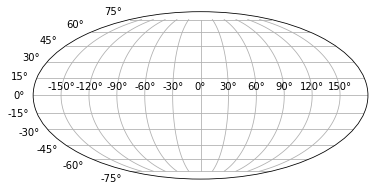

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide') 
plt.grid(True)

Koristeći se podacima iz http://tevcat.uchicago.edu stranice, stvara se u csv (engl. comma-seperated values) obliku tablica podataka koja se mora manipulirati unutar koda. Uporabom csv.reader() očitava se tablica te se za svaki stupac stvara lista uz pretpostavku da će biti potrebna ubuduće.

In [10]:
#pravi podaci
podaci=open('podaci.csv')
csvreader=csv.reader(podaci)
naslovi=[next(podaci)]

rows=[i for i in csvreader]

imena=[i[0] for i in rows]
ra1=[i[1] for i in rows]
dec1=[i[2] for i in rows]
types=[i[3] for i in rows]
datumi=[i[4] for i in rows]
udaljenosti=[i[5] for i in rows]


U ovom su trenutku najnužniji podatci za rektascenziju (eng. right ascension) i deklinaciju. Provjeravajući te podatke uočavaju se mnogobrojni problemi koje je potrebno popraviti. Navedeni brojevi kod rektascenzije predstavljaju sate, minute i sekunde, a kod deklinacije stupnjeve, minute i sekunde. Oni su odvojeni razmakom te su svi zajedno predstavljeni u tekstualnom obliku (eng. string).

In [12]:
print(type(ra1[0]))
print(type(dec1[0]))
print(ra1[:10])
print(dec1[:10])

<class 'str'>
<class 'str'>
['00 02 07.6', '00 06 26', '00 13 52.0', '00 25 21.6', '00 33 36', '00 35 16.8', '00 47 32.54', '01 05 28.88', '01 12 05.8', '01 36 32.5']
['-02 56 06', '+72 59 01.0', '-18 53 29', '+64 07 48', '-19 21 00', '+59 47 24.0', '-25 17 25.4', '+16 30 58.0', '+22 44 39', '+39 06 00']


Problem tekstualnog oblika podataka rješava se tako da se podatci pretvore u decimalni oblik pomoću navedenog koda:

In [5]:
#RA
iznosi_ra=[]
for i in ra1:
	ra2=i.split(' ')
	iznos=float(ra2[0])*15 +float(ra2[1])/60 + float(ra2[2])/3600
	iznos=iznos*15
	iznosi_ra.append(iznos)		

ra=np.array(iznosi_ra)


#DEC	
iznosi_dec=[]

for i in dec1:
	dec2=i.split(' ')
	if float(dec2[0])>0:
		iznos2=float(dec2[0]) + float(dec2[1])/60 + float(dec2[2])/3600	
	else:
		iznos2=float(dec2[0]) - float(dec2[1])/60 - float(dec2[2])/3600	
	iznosi_dec.append(iznos2) 

dec=np.array(iznosi_dec)

Može se uočiti kako su podatci uspješno pretvoreni iz “string” u “float” oblik. Za primjer prikazujemo podatke deklinacija prvih 10 izvora.

In [9]:
print(type(dec[0]))

for i in range(10):
    print("{} = {}".format(dec1[i],dec[i]))

<class 'str'>
<class 'numpy.float64'>
-02 56 06 = -2.935
+72 59 01.0 = 72.98361111111112
-18 53 29 = -18.891388888888887
+64 07 48 = 64.13
-19 21 00 = -19.35
+59 47 24.0 = 59.79
-25 17 25.4 = -25.29038888888889
+16 30 58.0 = 16.516111111111112
+22 44 39 = 22.74416666666667
+39 06 00 = 39.1


Slijedeći korak jest kreiranje nove csv tablice pomoću koje se stvara kartu. To se može uraditi uporabom csv.writer() preko se dobiva tablica s prepoznatljivim oblikom podataka.

In [25]:

"""
with open('podaci_novo.csv','w',newline='') as file:
	writer=csv.writer(file)
	writer.writerow([naslovi[0][i] for i in range(6)])
	for i in range(len(rows)):
		writer.writerow([imena[i],iznosi_ra[i],iznosi_dec[i],types[i],datumi[i],udaljenosti[i]])
"""

"\nwith open('podaci_novo.csv','w',newline='') as file:\n\twriter=csv.writer(file)\n\twriter.writerow([naslovi[0][i] for i in range(6)])\n\tfor i in range(len(rows)):\n\t\twriter.writerow([imena[i],iznosi_ra[i],iznosi_dec[i],types[i],datumi[i],udaljenosti[i]])\n"

Koristeći se QTable-om i SkyCoord-om iz astropy paketa stvorena je nova tablica unutar koda koja olakšava korištenje mjernih jedinica unutar Pythona.

In [16]:
tbl=QTable.read('podaci_novo.csv')
qtbl=SkyCoord(ra=tbl['RA']*u.deg,dec=tbl['Dec']*u.deg)

print(tbl[:10])

         Name                 RA         ...   Date     Dist  
--------------------- ------------------ ... ------- ---------
          GRB 180720B 0.5316666666666667 ... 2019.05 z = 0.654
                CTA 1 1.6083333333333334 ...  2011.1   1.4 kpc
SHBL J001355.9-185406  3.466666666666667 ... 2010.11 z = 0.095
                Tycho  6.340000000000001 ... 2010.05   3.5 kpc
       KUV 00311-1938                8.4 ... 2012.07        --
         1ES 0033+595               8.82 ...  2011.1 z = 0.467
              NGC 253 11.885583333333333 ... 2009.07  2500 kpc
          GRB 201216C  16.37033333333333 ... 2020.12   z = 1.1
           S2 0109+22 18.024166666666666 ... 2015.07        --
        RGB J0136+391 24.135416666666668 ... 2012.07        --


Zatim se koristi Galactic naredba koja kroz podatke za rektascenziju (RA) i deklinaciju (DEC) prikazuje galaktičke koordinate za svaki VHE-izvor.

In [17]:
qtbl_g=qtbl.galactic

print(qtbl[:10])

<SkyCoord (ICRS): (ra, dec) in deg
    [( 0.53166667,  -2.935     ), ( 1.60833333,  72.98361111),
     ( 3.46666667, -18.89138889), ( 6.34      ,  64.13      ),
     ( 8.4       , -19.35      ), ( 8.82      ,  59.79      ),
     (11.88558333, -25.29038889), (16.37033333,  16.51611111),
     (18.02416667,  22.74416667), (24.13541667,  39.1       )]>


Kako bi se prepoznali različiti VHE-izvori mora ih se podjeliti po bojama. To je moguće uz pomoć stvaranja mnogo različitih lista. Svaka navedena lista prikazuje boju u koju se određene vrste izvora svrštavaju. Pošto postoji previše različitih VHE-izvora, najlakše ih je grupirati po sličnosti.


In [18]:
types_n=[]
types_purple=['PWN' , 'PWN/TeV Halo','TeV Halo']
types_blue=['Globular Cluster','BL Lac (class unclear)','Massive Star Cluster']
types_red=['AGN (unknown type)', 'HBL','LBL','Blazar','FRI','IBL','GRB','FSRQ']
types_green=['Shell','Giant Molecular Cloud','SNR/Molec. Cloud','Superbubble','Composite SNR','SNR']
types_grey=['UNID','DARK']
types_yellow=['Nova','Binary','PSR']
for i in types:
	if i=='Starburst':
		types_n.append('orange')
	elif i in types_purple:
		types_n.append('purple')
	elif i in types_blue:
		types_n.append('blue')
	elif i in types_red:
		types_n.append('red')
	elif i in types_green:
		types_n.append('green')
	elif i in types_grey:
		types_n.append('grey')
	elif i in types_yellow:
		types_n.append('yellow')	
	else:
		types_n.append(i)

Pomoću matplotlib paketa i pretvaranja galaktičkih koordinata u radijane mogu se prikazati točke (eng. scatters) na nebeskoj karti na slijedeći način:

Text(1.0, 1.0, 'Astronomija u području TeV')

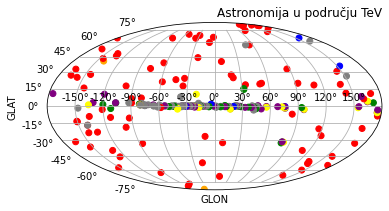

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide') 
plt.grid(True)
plt.xlabel("GLON")
plt.ylabel("GLAT")
sph = qtbl_g.spherical
cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,sph.lat.radian,c=types_n)
plt.title(label="Astronomija u području TeV",loc="right")


U slučaju urednijeg prikaza određenih grupa izvora, nužno je napraviti još nekoliko novih lista pomoću koje se pravi bolja i detaljnija podjela točaka. U navedenim listama se preko “for” petlje smještaju galaktičke koordinate u radijanima za svaku grupu VHE-izvora.

In [20]:
orange_lon=[]
orange_lat=[]
purple_lon=[]
purple_lat=[]
blue_lon=[]
blue_lat=[]
red_lon=[]
red_lat=[]
green_lon=[]
green_lat=[]
grey_lon=[]
grey_lat=[]
yellow_lon=[]
yellow_lat=[]


#print(types)
broj=-1

for i in types:
	broj=broj+1
	if i=='Starburst':
		orange_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		orange_lat.append(sph.lat[broj].radian)
	elif i in types_purple:
		purple_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		purple_lat.append(sph.lat[broj].radian)
	elif i in types_blue:
		blue_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		blue_lat.append(sph.lat[broj].radian)
	elif i in types_red:
		red_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		red_lat.append(sph.lat[broj].radian)
	elif i in types_green:
		green_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		green_lat.append(sph.lat[broj].radian)
	elif i in types_grey:
		grey_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		grey_lat.append(sph.lat[broj].radian)
	elif i in types_yellow:
		yellow_lon.append(-sph.lon[broj].wrap_at(180*u.deg).radian)
		yellow_lat.append(sph.lat[broj].radian)	
	else:
		print("neuspjesno")


Novi podatci u listama preobražavaju se u skupine točaka koje se kategoriziraju gdje c (engl. color) predstavlja argument za boju:

In [22]:
cs1=ax.scatter(np.array(orange_lon),np.array(orange_lat),c="orange")
cs2=ax.scatter(np.array(purple_lon),np.array(purple_lat),c="purple")
cs3=ax.scatter(np.array(blue_lon),np.array(blue_lat),c="blue")
cs4=ax.scatter(np.array(red_lon),np.array(red_lat),c="red")
cs5=ax.scatter(np.array(green_lon),np.array(green_lat),c="green")
cs6=ax.scatter(np.array(grey_lon),np.array(grey_lat),c="grey")
cs7=ax.scatter(np.array(yellow_lon),np.array(yellow_lat),c="yellow")


Iz matplotlib paketa uzima se RadioButtons koji omogućuje prikazivanje tipki. Pomoću funkcije set_visible moguće je na karti razdvojiti navedene grupe točaka po želji.

In [23]:
from matplotlib.widgets import (RadioButtons)
scatters=(cs1,cs2,cs3,cs4,cs5,cs6,cs7)
labels=('Starburst','PWN, PWN/TeV HaloTeV, Halo','Globular Cluster,BL Lac (class unclear),Massive Star Cluster','AGN (unknown type), HBL,LBL,Blazar,FRI,IBL,GRB,FSRQ','Shell,Giant Molecular Cloud,SNR/Molec. Cloud,Superbubble,Composite SNR,SNR','UNID,DARK','Nova,Binary,PSR')


def set_visible(label_names):
	option_index=labels.index(label_names)
	for i, val in enumerate(scatters):
		if i==option_index:
			scatters[i].set_visible(True)
		else:
			scatters[i].set_visible(False)
		plt.draw()


Pomoću različitih gadgeta iz matplotlib paketa može se kod urediti svojevoljno. Kad se sve to zajedno kombinira dobiva konačna slika sa gadgetima koja olakšava prikaz.

0

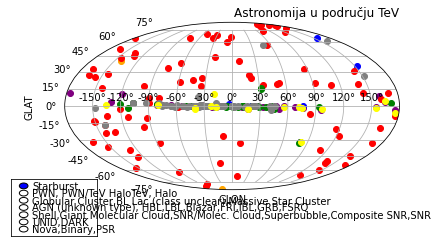

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide') 
plt.grid(True)
plt.xlabel("GLON")
plt.ylabel("GLAT")
cs1=ax.scatter(np.array(orange_lon),np.array(orange_lat),c="orange")
cs2=ax.scatter(np.array(purple_lon),np.array(purple_lat),c="purple")
cs3=ax.scatter(np.array(blue_lon),np.array(blue_lat),c="blue")
cs4=ax.scatter(np.array(red_lon),np.array(red_lat),c="red")
cs5=ax.scatter(np.array(green_lon),np.array(green_lat),c="green")
cs6=ax.scatter(np.array(grey_lon),np.array(grey_lat),c="grey")
cs7=ax.scatter(np.array(yellow_lon),np.array(yellow_lat),c="yellow")
plt.title(label="Astronomija u području TeV",loc="right")
button1=plt.axes([0.0,0.05,0.2,0.2])  #left,bottom,width,height
radio_button=RadioButtons(button1,labels)
radio_button.on_clicked(set_visible)
